# **Predicting Life Expectancy in Japanese Prefectures**
---
### **Introduction**

Life expectancy is a crucial measure of the overall health and well-being of populations. Understanding the factors that influence life expectancy can help governments and policymakers make data-driven decisions to improve public health outcomes. In this project, we aim to predict life expectancy across various prefectures in Japan using socio-economic, healthcare, and environmental factors.

The dataset contains various features such as the number of physicians, hospitals, healthcare expenditures, education levels, and income per capita, among others. By applying machine learning techniques, we hope to identify key drivers of life expectancy and create a predictive model that can accurately estimate life expectancy based on the provided features.

### **Objectives**
- Perform exploratory data analysis (EDA) to understand the relationships between features.
- Build and evaluate multiple machine learning models to predict life expectancy.
- Analyze feature importance to identify the most impactful factors.
- Provide insights into the factors influencing life expectancy across Japanese prefectures.


### **Load the dataset**

In [ ]:
!pip install kaggle pandas numpy scikit-learn matplotlib seaborn

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list
!kaggle datasets list -s "life expectancy"
!kaggle datasets download -d gianinamariapetrascu/japan-life-expectancy --unzip

In [ ]:
import pandas as pd
df = pd.read_csv('Japan_life_expectancy.csv')
df

### **Exploratory Data Analysis**

In [ ]:
df.info()
df.describe()
missing_values = df.isnull().sum()
print(f"Missing values in each of the columns:\n{missing_values}")

In [ ]:
import plotly.express as px
import pandas as pd

life_expectancy_data = pd.DataFrame(df['Life_expectancy'])

fig = px.histogram(life_expectancy_data,
                   x='Life_expectancy',
                   nbins=20,
                   title='Distribution of Life Expectancy')
fig.show()

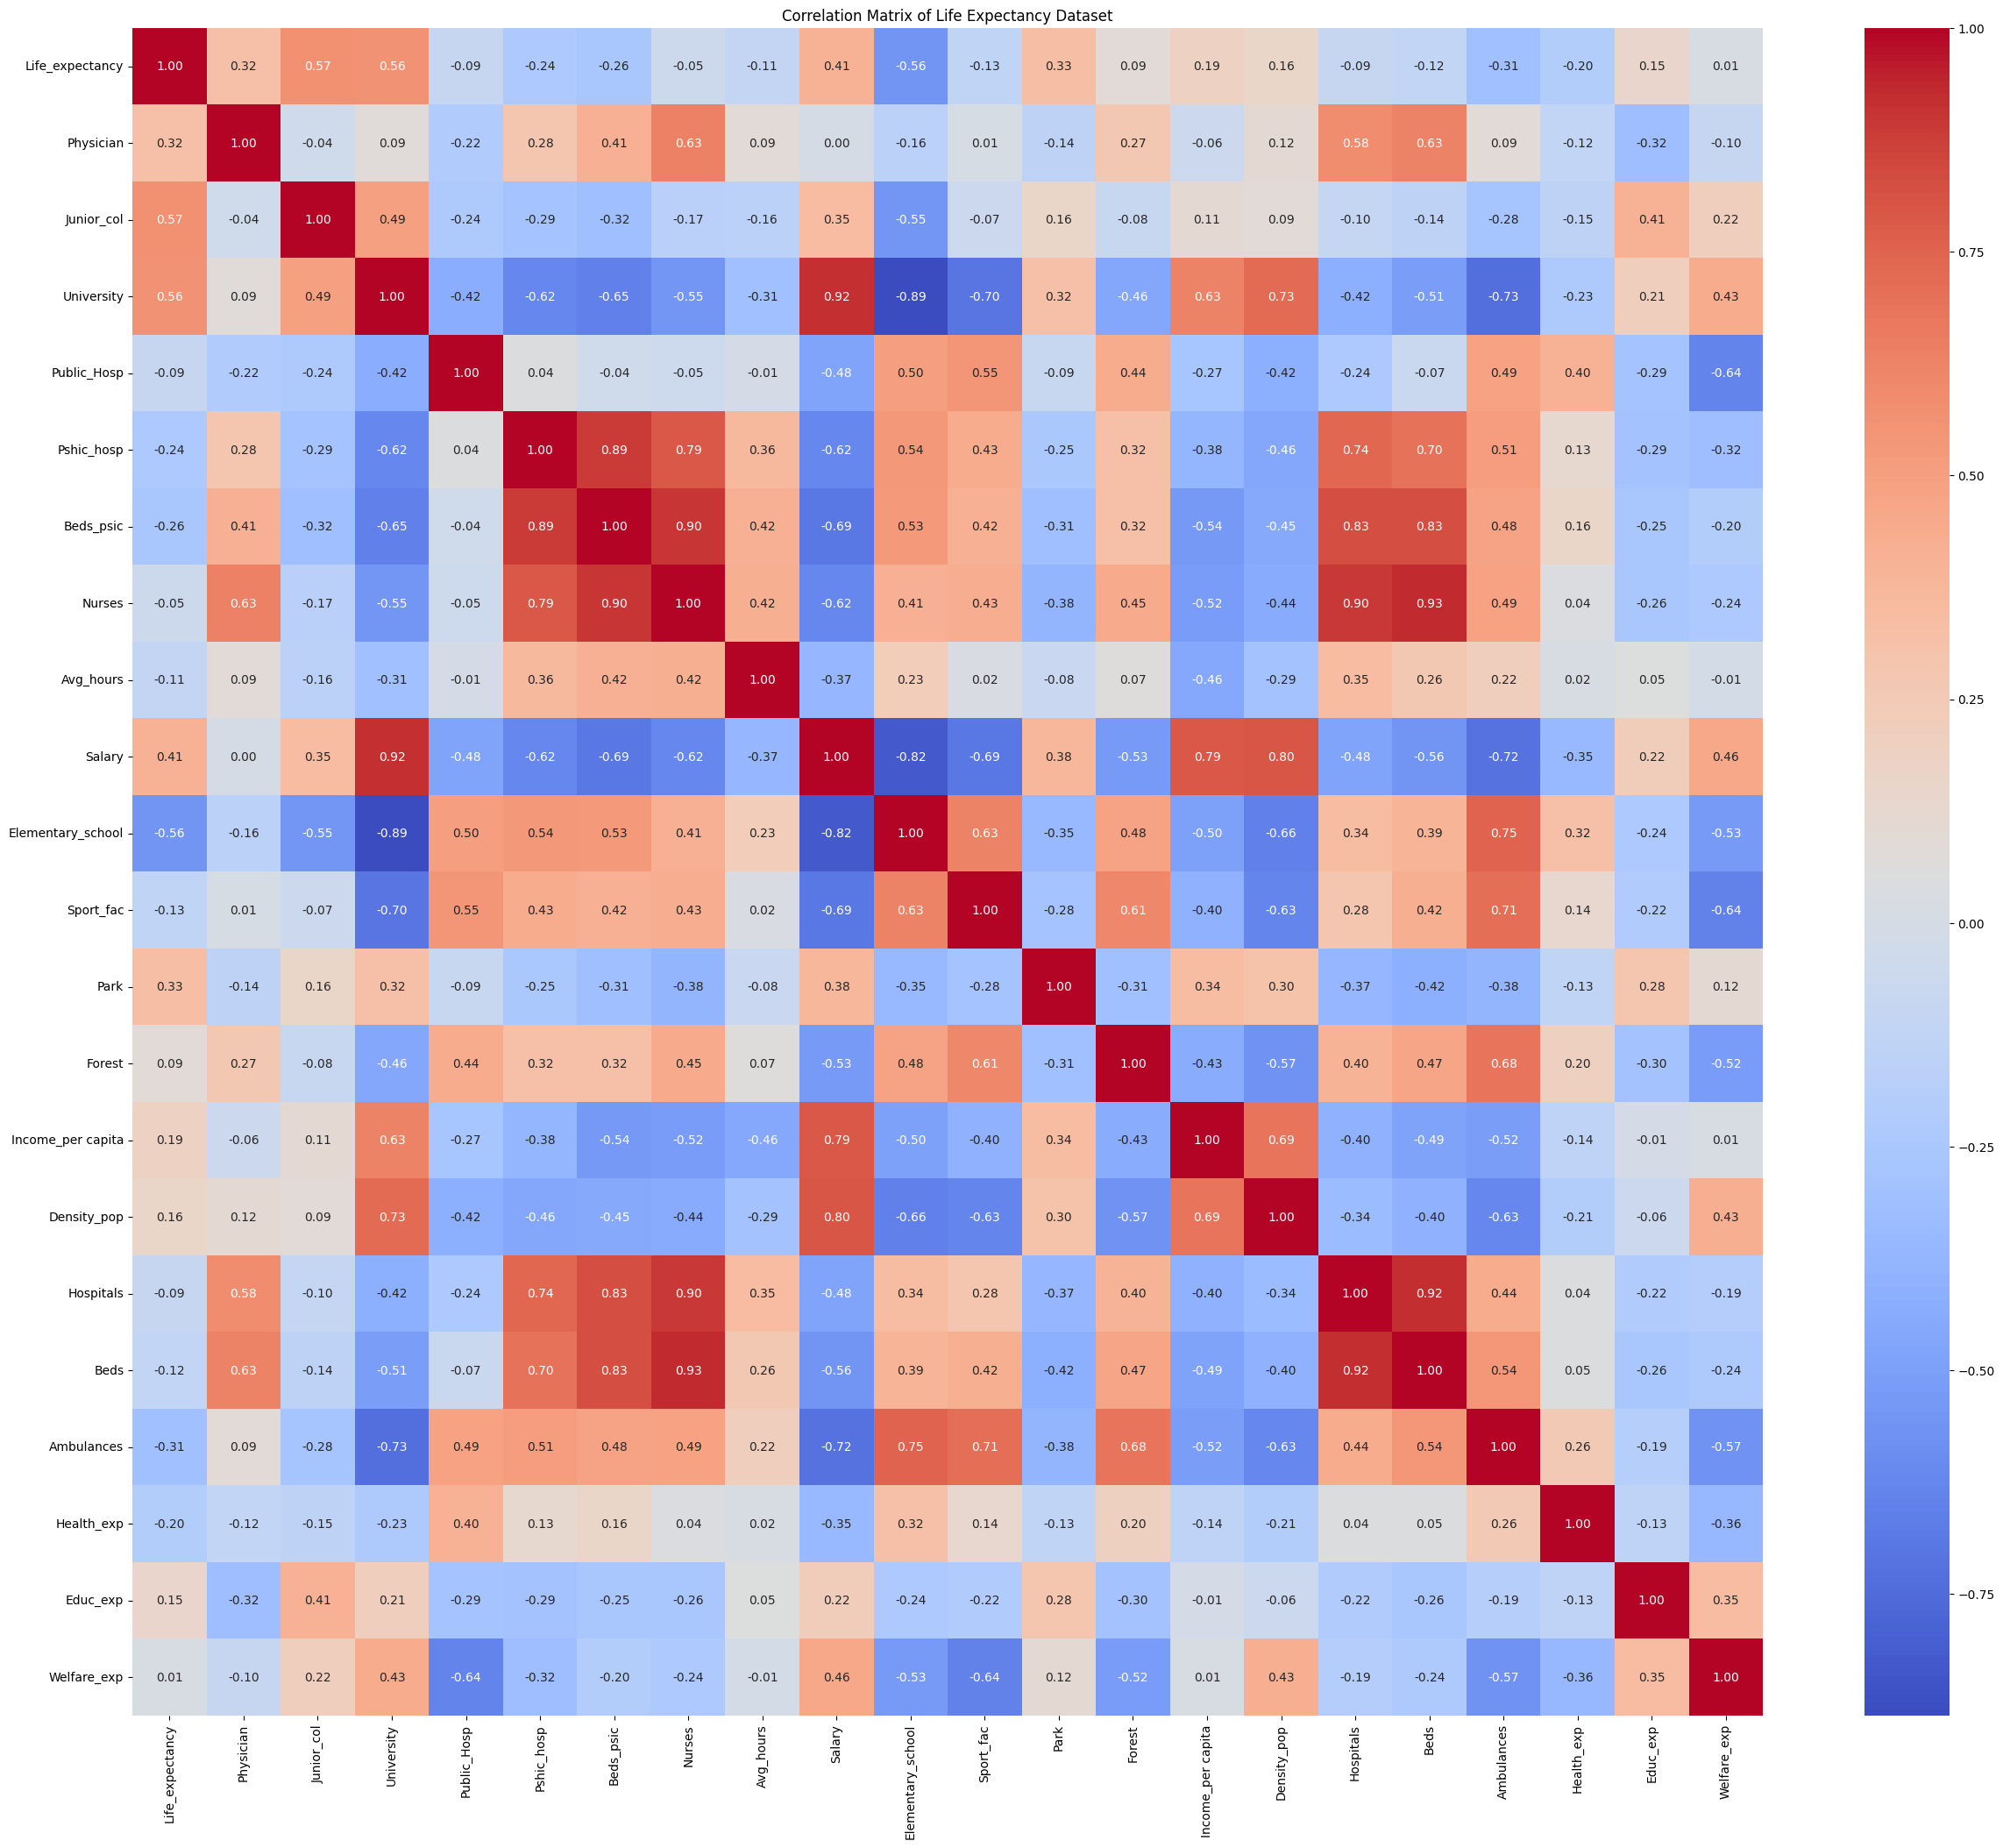

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_numeric = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = df_numeric.corr()

plt.figure(figsize=(30, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Life Expectancy Dataset')
plt.show()

In [ ]:
import plotly.express as px

fig1 = px.scatter(df, x='Health_exp', y='Life_expectancy',
                  title='Life Expectancy vs Health Expenditure',
                  labels={'Health_exp':'Health Expenditure (% of GDP)',
                          'Life_expectancy':'Life Expectancy'},
                  trendline='ols',
                  template='plotly_white')

fig1.update_traces(selector=dict(mode='lines'), line=dict(dash='dash', color='lightgrey'))

fig2 = px.scatter(df, x='Physician', y='Life_expectancy',
                  title='Life Expectancy vs Number of Physicians',
                  labels={'Physician':'Number of Physicians (per 1000 people)',
                          'Life_expectancy':'Life Expectancy'},
                  trendline='ols',
                  template='plotly_white')

fig2.update_traces(selector=dict(mode='lines'), line=dict(dash='dash', color='lightgrey'))

fig3 = px.scatter(df, x='Beds', y='Life_expectancy',
                  title='Life Expectancy vs Number of Beds',
                  labels={'Beds':'Number of Beds (per 1000 people)',
                          'Life_expectancy':'Life Expectancy'},
                  trendline='ols',
                  template='plotly_white')

fig3.update_traces(selector=dict(mode='lines'), line=dict(dash='dash', color='lightgrey'))

fig1.show()
fig2.show()
fig3.show()

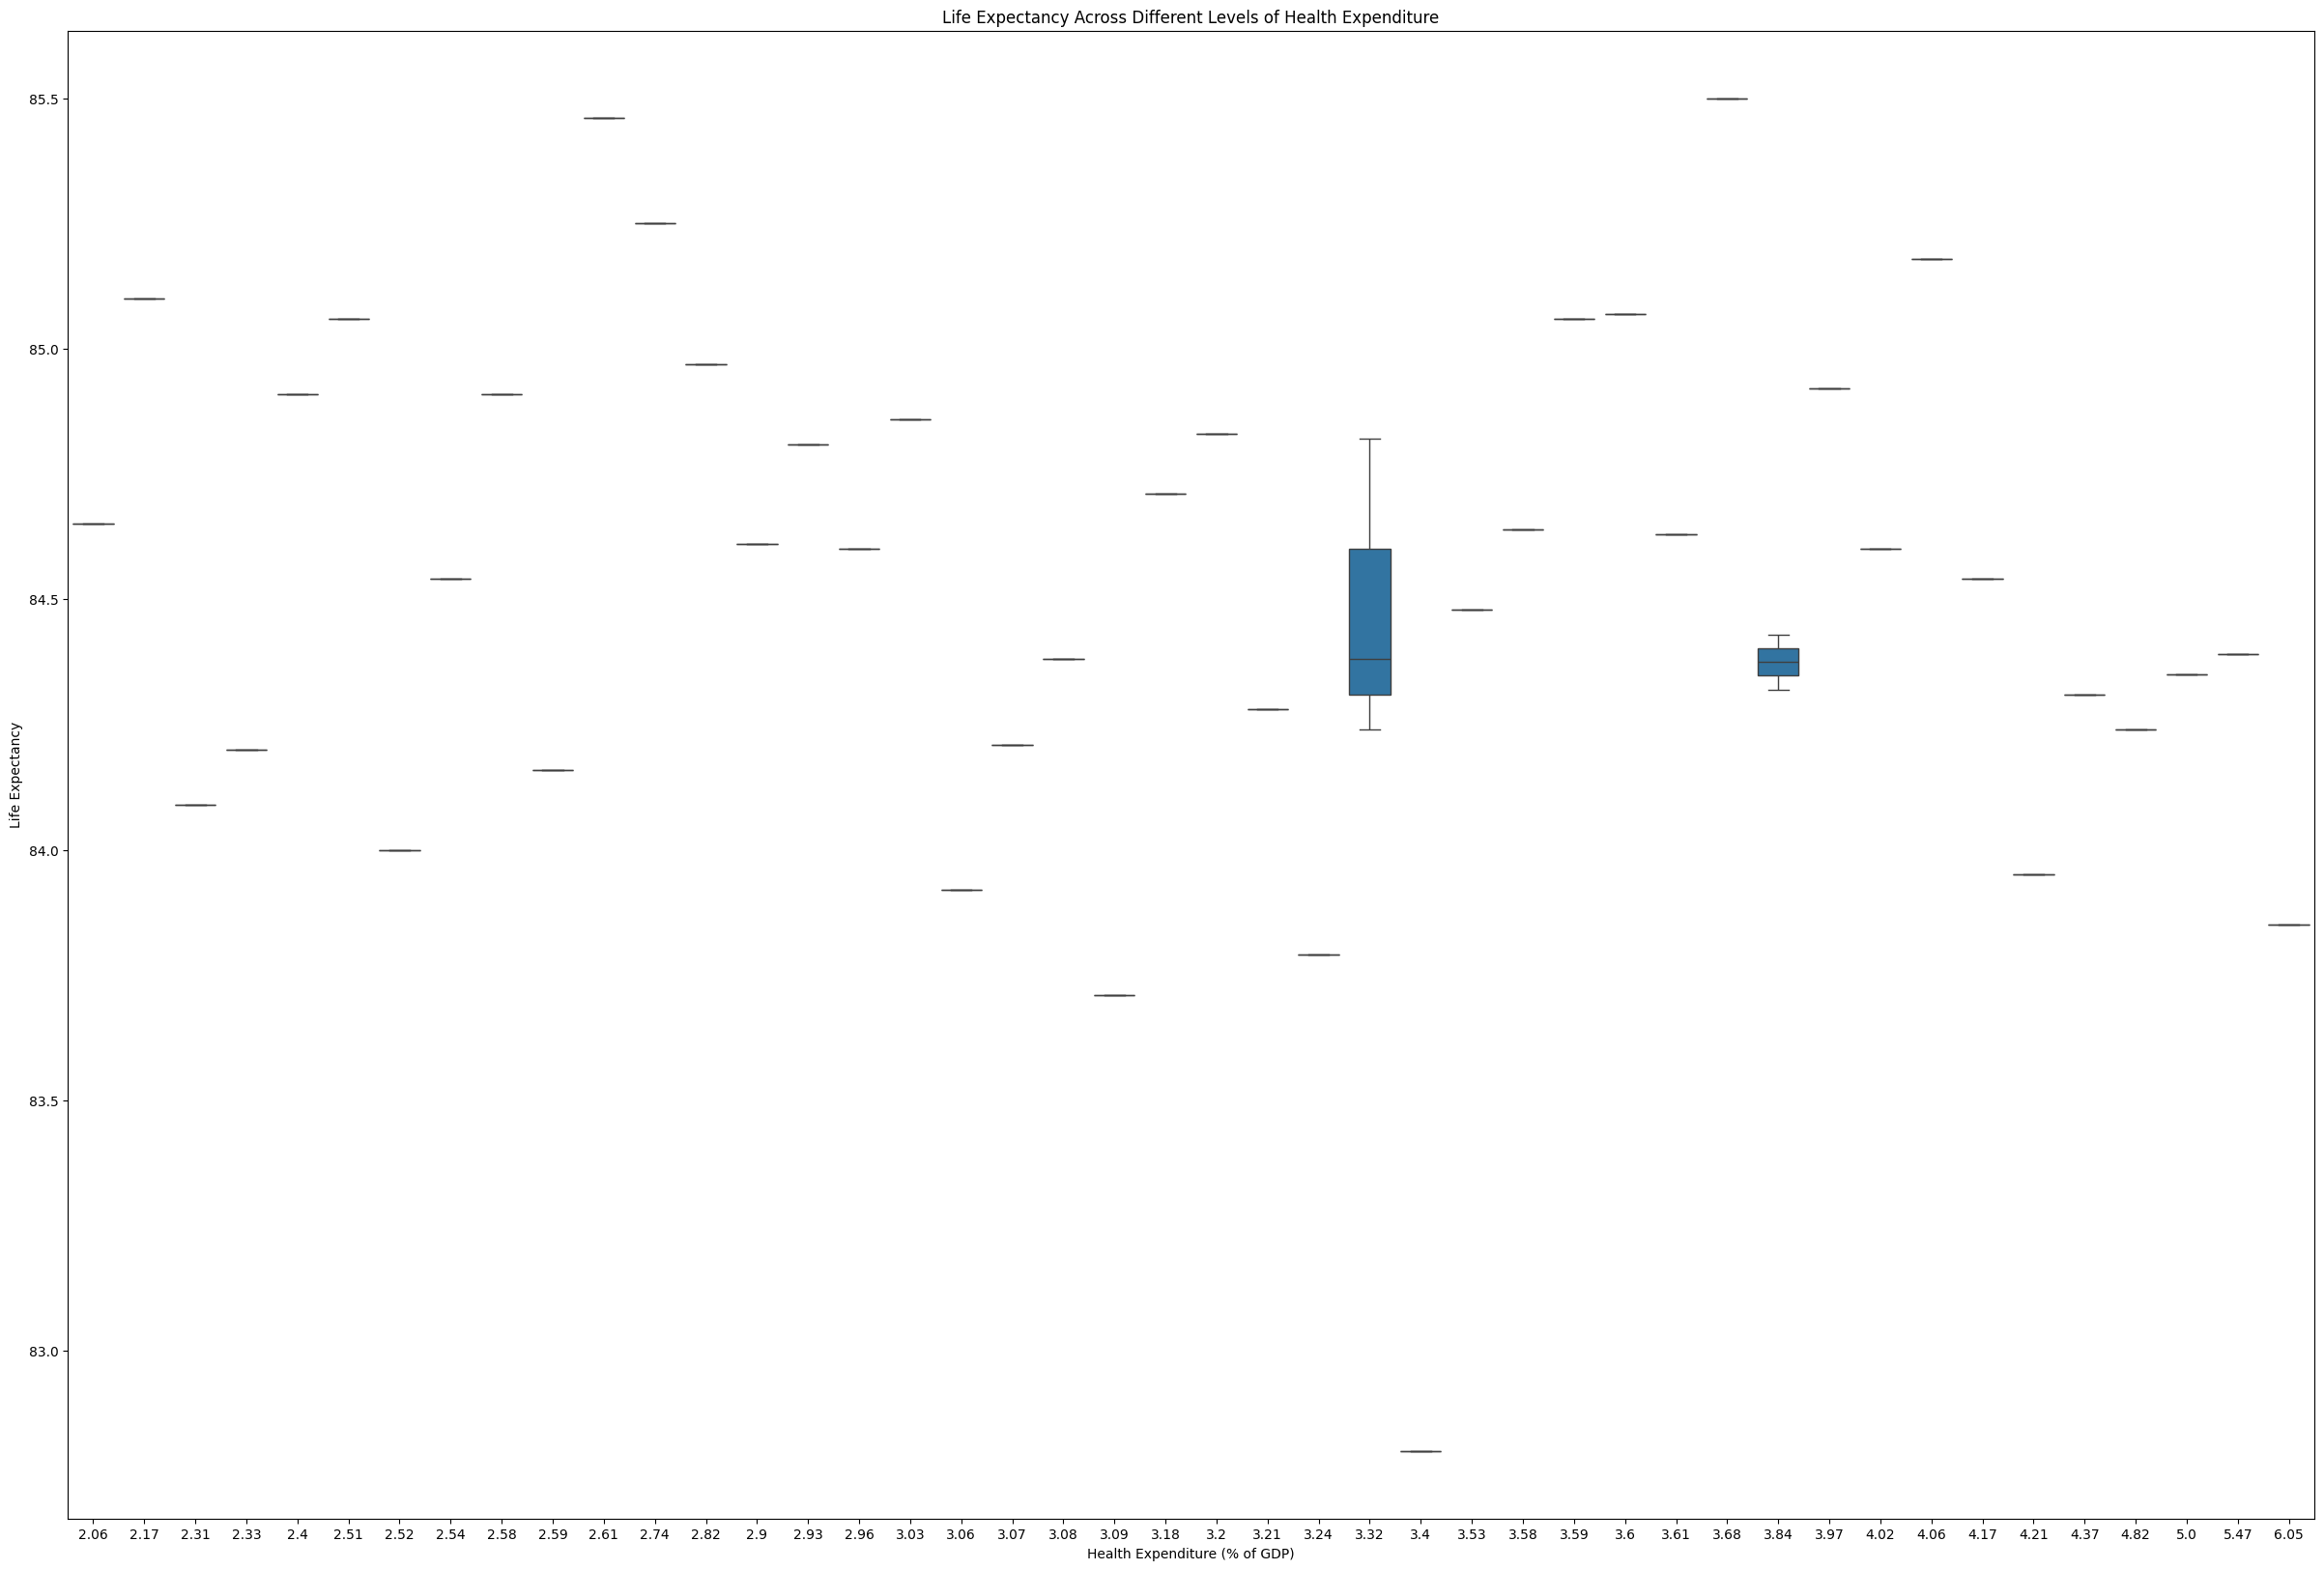

In [ ]:
plt.figure(figsize=(25, 15))
sns.boxplot(x='Health_exp', y='Life_expectancy', data=df)
plt.title('Life Expectancy Across Different Levels of Health Expenditure')
plt.xlabel('Health Expenditure (% of GDP)')
plt.ylabel('Life Expectancy')
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import pandas as pd

X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Life_expectancy'])
y = df['Life_expectancy']
ridge_model = Ridge()
rfe = RFE(estimator=ridge_model, n_features_to_select=5)
rfe.fit(X, y)

rfe_ranking = pd.Series(rfe.ranking_, index=X.columns)
selected_features_rfe = rfe_ranking[rfe_ranking == 1].index.tolist()
print("Selected Features using RFE:", selected_features_rfe)

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X, y)

feature_importances = pd.Series(random_forest_model.feature_importances_, index=X.columns)
selected_features_rf = feature_importances.nlargest(5).index.tolist()
print("Selected Features using Random Forest:", selected_features_rf)


X_rfe = X[selected_features_rfe]
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5)
ridge_grid.fit(X_train_rfe, y_train_rfe)
y_pred_rfe_ridge = ridge_grid.predict(X_test_rfe)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5)
rf_grid.fit(X_train_rfe, y_train_rfe)
y_pred_rfe_rf = rf_grid.predict(X_test_rfe)

print("Evaluation with RFE selected features and hyperparameter tuning:")

def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print("\n")

evaluate_model(y_test_rfe, y_pred_rfe_ridge, "Ridge Regression (RFE Features with Tuning)")

evaluate_model(y_test_rfe, y_pred_rfe_rf, "Random Forest Regression (RFE Features with Tuning)")

X_rf = X[selected_features_rf]
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

ridge_grid.fit(X_train_rf, y_train_rf)
y_pred_rf_ridge = ridge_grid.predict(X_test_rf)

rf_grid.fit(X_train_rf, y_train_rf)
y_pred_rf_rf = rf_grid.predict(X_test_rf)

evaluate_model(y_test_rf, y_pred_rf_ridge, "Ridge Regression (RF Features with Tuning)")
evaluate_model(y_test_rf, y_pred_rf_rf, "Random Forest Regression (RF Features with Tuning)")

Selected Features using RFE: ['Junior_col', 'Pshic_hosp', 'Elementary_school', 'Health_exp', 'Welfare_exp']
Selected Features using Random Forest: ['University', 'Junior_col', 'Elementary_school', 'Public_Hosp', 'Density_pop']
Evaluation with RFE selected features and hyperparameter tuning:
--- Ridge Regression (RFE Features with Tuning) ---
Mean Absolute Error: 0.2643
Mean Squared Error: 0.1141
R² Score: 0.3842


--- Random Forest Regression (RFE Features with Tuning) ---
Mean Absolute Error: 0.2663
Mean Squared Error: 0.1201
R² Score: 0.3519




  Prefecture  Life_expectancy  Physician  Junior_col  University  Public_Hosp  \
0      Aichi            84.65      224.4        13.6        23.7         13.7   
1      Akita            83.79      242.6        11.3        11.9         34.0   
2     Aomori            82.80      212.5        11.4        11.8         42.9   
3      Chiba            84.48      205.8        14.7        24.9         16.1   
4      Ehime            84.24      276.7        14.2        18.0         17.4   

   Pshic_hosp  Beds_psic  Nurses  Avg_hours  ...  Park  Forest  \
0         0.5      164.3   845.4      171.5  ...  17.2    42.1   
1         1.7      404.6  1105.5      173.0  ...  10.6    70.3   
2         1.4      348.7  1108.8      174.5  ...  11.8    63.6   
3         0.5      195.8   749.1      173.5  ...   5.5    30.1   
4         1.0      329.7  1277.5      178.0  ...   7.2    70.5   

   Income_per capita  Density_pop  Hospitals    Beds  Ambulances  Health_exp  \
0             3728.0       2517.7   

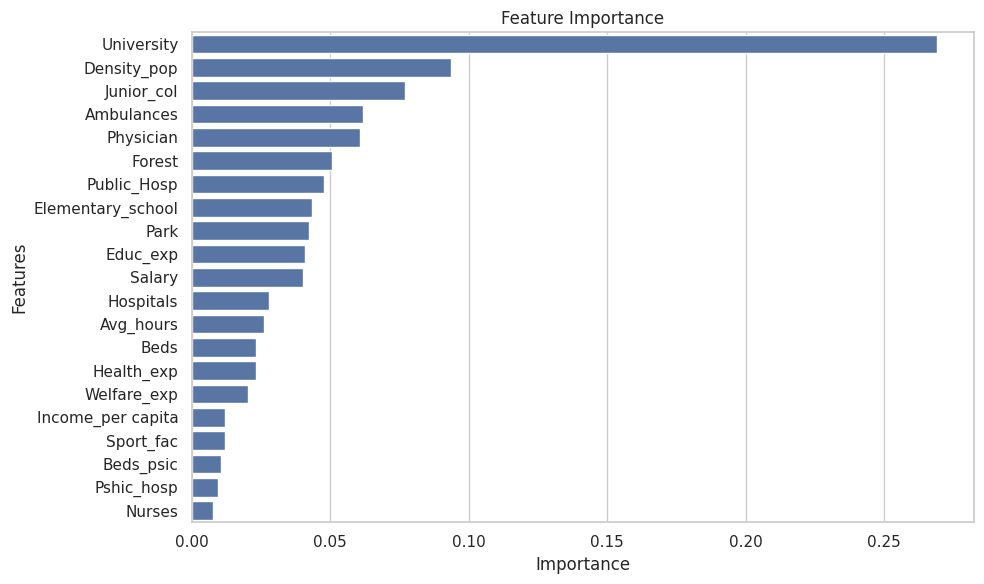

Test RMSE: 0.41


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

X = df.drop(['Prefecture', 'Life_expectancy'], axis=1)
y = df['Life_expectancy']

X.fillna(X.mean(), inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{name} RMSE: {rmse_scores.mean():.2f}")

best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

importances = best_model.feature_importances_
feature_names = df.drop(['Prefecture', 'Life_expectancy'], axis=1).columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse:.2f}")

## **Conclusion**
---

In this project, we successfully built a predictive model for life expectancy across Japanese prefectures using socio-economic and healthcare-related features. After experimenting with several machine learning models, including Linear Regression, Ridge, Lasso, Random Forest, and Gradient Boosting, **Random Forest** emerged as the best-performing model with an RMSE of 0.41.

Key insights from the analysis include:
- **Healthcare Expenditure** and **Public Hospital Availability** were found to be significant predictors of life expectancy.
- Socio-economic factors like **Income per Capita** and **Education Levels** also play a crucial role in determining life expectancy.
- Through feature importance analysis, we identified that **Junior College Education**, **Psychiatric Hospital Availability**, and **University Education** are some of the most influential features in the model.

Further improvements can be made by tuning the models more extensively and exploring more advanced feature engineering techniques. Overall, this model can serve as a starting point for more sophisticated analyses that aim to inform healthcare policies and resource allocation to improve public health outcomes in Japan.
